In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.layers import Conv1D, TimeDistributed, Flatten, SpatialDropout1D, GlobalAveragePooling1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
from numpy import genfromtxt

/Users/niall/opt/anaconda3/envs/DCUML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/niall/opt/anaconda3/envs/DCUML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/niall/opt/anaconda3/envs/DCUML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/niall/opt/anaconda3/envs/DCUML

In [18]:
def get_data():
    input_file = '/Users/niall/Documents/Cypress_Code/Data/Multipath/channel_1_multipath_power_data.csv'
    my_data_flipped = genfromtxt(input_file, delimiter=',')

    new_data = np.delete(my_data_flipped, (0), axis=0)
    X2 = np.delete(new_data, (0,39), axis=1)
    Y2 = new_data[:,39]
    X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.25, random_state=42, shuffle=True)
    X_train = np.array(X_train).reshape((np.shape(X_train)[0], 1, np.shape(X_train)[1]))
    X_test = np.array(X_test).reshape((np.shape(X_test)[0], 1, np.shape(X_test)[1]))

    return X_train, X_test, y_train, y_test

In [19]:
flip_bit_data = get_data()

In [20]:
X_train = flip_bit_data[0]
X_test = flip_bit_data[1]
y_train = flip_bit_data[2]
y_test = flip_bit_data[3]

In [21]:
num_neurons = 38
num_features = 38


model_bidir = Sequential()
model_bidir.add(Bidirectional(LSTM(num_neurons, return_sequences=True),input_shape=(1, num_features)))
model_bidir.add(Bidirectional(LSTM(num_neurons, return_sequences=True),input_shape=(1, num_features)))
model_bidir.add(GlobalMaxPooling1D())
model_bidir.add(Dense(16, activation='sigmoid'))
model_bidir.add(Dropout(0.2))
model_bidir.add(Dense(1, activation='sigmoid'))


rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_bidir.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bidir.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 1, 76)             23408     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1, 76)             34960     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 76)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1232      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 59,617
Trainable params: 59,617
Non-trainable params: 0
_________________________________________________________________


In [22]:
print('Training BLSTM...')

batch_size = 5

history_one_blstm = model_bidir.fit(X_train, y_train, 
                                      batch_size=batch_size,
                                      epochs=5,
                                      validation_data=(X_test, y_test), 
                                      callbacks=[rlrp] ,verbose=1)

Training BLSTM...
Train on 390000 samples, validate on 130000 samples
Epoch 1/5
390000/390000 [==============================] - 780s 2ms/sample - loss: 0.0133 - acc: 0.9962 - val_loss: 0.0081 - val_acc: 0.9970
Epoch 2/5
390000/390000 [==============================] - 1125s 3ms/sample - loss: 0.0070 - acc: 0.9978 - val_loss: 0.0068 - val_acc: 0.9978
Epoch 3/5
390000/390000 [==============================] - 915s 2ms/sample - loss: 0.0056 - acc: 0.9982 - val_loss: 0.0068 - val_acc: 0.9977
Epoch 4/5
390000/390000 [==============================] - 853s 2ms/sample - loss: 0.0049 - acc: 0.9986 - val_loss: 0.0085 - val_acc: 0.9979
Epoch 5/5
390000/390000 [==============================] - 727s 2ms/sample - loss: 0.0025 - acc: 0.9993 - val_loss: 0.0105 - val_acc: 0.9979


130000/130000 [==============================] - 9s 68us/sample - loss: 0.0105 - acc: 0.99790s - loss: 0.0106 
Test Loss:  0.010483248198848364
Test Accuracy 0.99793077
dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


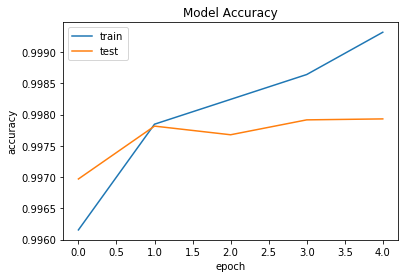

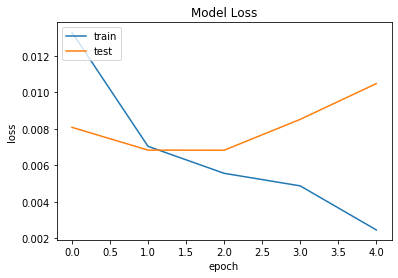

In [23]:
score = model_bidir.evaluate(X_test, y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history_one_blstm.history.keys())
# summarize history for accuracy
plt.plot(history_one_blstm.history['acc'])
plt.plot(history_one_blstm.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_one_blstm.history['loss'])
plt.plot(history_one_blstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
# Let's save the model to disc
json = model_bidir.to_json()
with open("/Users/niall/Documents/Cypress_Code/Models/BLSTM/Multipath/model_one_channel_one_power.json", "w") as file:
    file.write(json)
model_bidir.save_weights("/Users/niall/Documents/Cypress_Code/Models/BLSTM/Multipath/model_one_channel_one_power.h5")
print("Saved model to disc")

Saved model to disc


In [25]:
# Load the model of interest
json_file = open('/Users/niall/Documents/Cypress_Code/Models/BLSTM/Multipath/model_one_channel_one_power.json', 'r')
json = json_file.read()
json_file.close()
model_avg_from_disc = model_from_json(json)
model_avg_from_disc.load_weights("/Users/niall/Documents/Cypress_Code/Models/BLSTM/Multipath/model_one_channel_one_power.h5")

In [26]:
y_preds_lstm_minus = model_avg_from_disc.predict(X_test, batch_size=1)

In [27]:
pred_avg = pd.DataFrame(y_preds_lstm_minus, columns =['Y_pred']) 
pred_avg['Label'] = y_test

In [28]:
pred_avg.to_csv('/Users/niall/Documents/Cypress_Code/Predictions/BLSTM/Multipath/model_one_channel_one_power.csv', index = False)

In [29]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))

In [30]:
preds_new = model_avg_from_disc.predict_classes(X_test)
metrics(preds_new, y_test)

F1-score:  0.9978495311338328
Precision:  0.9980330385556426
Recall:  0.9976660911823007
Acuracy:  0.9979307692307692
--------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67444
           1       1.00      1.00      1.00     62556

    accuracy                           1.00    130000
   macro avg       1.00      1.00      1.00    130000
weighted avg       1.00      1.00      1.00    130000

